In [245]:
## Standard imports + some extra imports for 3d plots
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [258]:
## Defining All functions here
# Tolerance Calculation
def L1norm(new, old):
    '''
    Calculates L1 Norm
    ----------
    Parameters:
    ----------
    new: 2D array of floats
        Current values to calculate L1 Norm
    old: 2D array of floats
        Original values to calculate L1 Norm 
    -------
    Returns:
    -------
    norm: float
        Calculated L1 Norm
    '''
    norm = numpy.sum(numpy.abs(new-old))
    return norm

# Poisson Relaxation
def poisson_2d(p, b, dx, dy):
    '''
    Performs  Poisson Jacobi relaxation for a single iteration
    ----------
    Parameters:
    ----------
    p: 2D array of floats
        Initial guess
    b: 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction    
    -------
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    norm: float
        L1norm after one iteration of relaxation
    '''
    # Setting Boundary Conditions
    # p[-1,:] = 0 # top Dirichlet - psi
    # p[0,:] = 0 # bottom Dirichlet - psi
    # p[:,0] = 0 # left Dirichlet - psi
    # p[:,-1] = 0 # right Dirichlet - psi
    
    # Given Guess of zeros, BC's are satisfied.
    
    pd = p.copy() # Dummy Variable used in calculating the new p and the norm, keeps original
    
    p[1:-1,1:-1] = 1/(2*(dx**2+dy**2))*\
        ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2+\
        (pd[2:,1:-1]+pd[:-2,1:-1])*dx**2-\
        b[1:-1,1:-1]*dx**2*dy**2)
    
    
    # Get the Norm
    norm = L1norm(p,pd)
    return p,pd,norm 

# Laplace Relaxation
def laplace_2d(p, b, dx, dy):
    '''
    Performs  Laplace Jacobi relaxation for a single iteration
    ----------
    Parameters:
    ----------
    p: 2D array of floats
        Initial guess
    b: 2D vector of floats
        psi needed for initial conditions 
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction    
    -------
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    norm: float
        L1norm after one iteration of relaxation
    '''     
   
    pn = p.copy()
   
    # Apply boundary conditions
    p[-1,:] = -0.5/(dy**2)*(8*b[-2,:] - b[-3,:]) -3/dy # assumes u_j = 1, always at the top boundary
    p[:,0] = -0.5/(dx**2)*(8*b[:,1] - b[:,2]); # Left
    p[:,-1] = -0.5/(dx**2)*(8*b[:,-2] - b[:,-3]); # Right
    p[0,:] = -0.5/(dy**2)*(8*b[1,:] - b[2,:]); # Bottom

    # Relax p
    p[1:-1,1:-1] = .25*(pn[1:-1,2:]+pn[1:-1,0:-2]+pn[2:,1:-1]+pn[0:-2,1:-1])
    
    # Get the Norm
    norm = L1norm(p, pn)
    return p,pn, norm

# Creating the plot3d method (I'd rather see the 3d then attempt a contour-can change viewing angle as needed)
def plot3d(x, y, p):
    '''
    Plots a 3D graph - Figure Appears with appropriate limits and viewing angle, No Return Values
    ----------
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    p: 2D array of float
        calculated potential field
    '''
    fig = pyplot.figure(figsize=(10,8), dpi=1000)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    
    # Cosmetics
    ax.set_xlim(0,1) # Domain given in problem
    ax.set_ylim(0,1) # Range given in problem
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

# Creating funciton to get maximum value of an array
def getmax(val):
    '''
    Gets maximum of absolute values of all elements in an array
    ----------
    Parameters:
    ----------
    val:2D array of floats
        array to be maximized   
    -------
    Returns:
    -------
    max: float
        value of maximum absolute value 
    '''
    max = numpy.amax(numpy.absolute(numpy.around(val,decimals=4)))
    return max

In [259]:
## Setting Up initial conditions
nx, ny = 41, 41 # Grid Size
l, h  = 1., 1. # Domain size
dx, dy = l/(nx-1), h/(ny-1) # Mesh Element size
x, y = numpy.linspace(0,1,nx), numpy.linspace(0,1,ny) # x and y for plots
l1_target = 1e-6 # Tolerance for solution

# Initializing solution arrays
psi = numpy.zeros((nx,ny))
w = numpy.zeros((nx,ny))

In [260]:
## Create/Simulate a Do While Loop
#  We want the solution to relax at least in one iteration so that we can caluculate the L1norm accurately.
#  This means we must have the loop run at least once. One way to do that is set an arbitrary conditional
#  boolean that we can then update based on our L1norm calculations after each iteration!
## <End Comment Block>

 # Create iteration count, for fun
iterations = 1
d_bool = True
while d_bool:

    # copy parameters
    psi_it = psi.copy()
    w_it = w.copy()
    
    ## Here we start our coupled solution of psi and w. 
    #  Step 1: relax psi, using -w as the forcing function - poisson relaxation
    #  Step 2: use the first two rows of psi in the new w equation and relax w, laplace relaxation
    #  Step 3: compare both norms to the target and see if we can break out of loop
    ## <End Comment Block>
    
    psi,pd, psi_norm = poisson_2d(psi_it, (-1*w_it), dx, dy) # Step 1
    w,wd, w_norm = laplace_2d(w_it, psi, dx, dy) # Step 2
    
    #print('psi_norm: ', psi_norm, " & w_norm: ", w_norm, "\n")
    iterations += 1
    if w_norm < l1_target and psi_norm < l1_target: # Step 3
        d_bool = False
        print("Iterations: ", iterations)


Iterations:  4061


(0.0, 1.0, 0.0, 1.0)

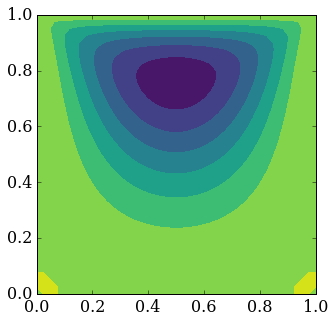

In [261]:
## plot psi
pyplot.figure(figsize=(5,5))
pyplot.contourf(x,y,psi,cmap=cm.viridis)
pyplot.axis('equal')


In [264]:
## Get max psi for question 1
print("max psi is: ", getmax(psi))

## Get max w for question 2
print("max w is: ", getmax(w))

## Get values for question 3
numpy.round(psi[32,::8], 4)

max psi is:  0.0998
max w is:  78.1927


array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])